# A quick introduction to CLIP Italian

In this notebook, we show how to instantiate our latest CLIP Italian checkpoint and use it to easly encode images and texts.  

# Initialization

In [ ]:
%%capture
!pip install transformers datasets gdown

We now download the Unsplash 25k dataset (credits: Nils Reimers) and their embeddings. Let [me](mailto:giuseppeattanasio6@gmail.com) know if Google Drive doesn't let you download them.



In [ ]:
%%capture
!wget -O unsplash.zip http://sbert.net/datasets/unsplash-25k-photos.zip
!unzip -q unsplash.zip -d unsplash
!gdown https://drive.google.com/uc?id=1U-R-0_90Xi_n6Tvwgl3okV6dqGO6HAJm

# Let's Start

In [ ]:
# @title Imports and Functions

import pandas as pd
import numpy as np
from PIL import Image
import requests
from tqdm import tqdm
import torch
import torch.nn.functional as F
from transformers import (
    VisionTextDualEncoderModel,
    AutoFeatureExtractor,
    AutoTokenizer
)
from glob import glob
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
sns.set_theme("notebook", font_scale=1.3)
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox
from transformers import VisionTextDualEncoderModel
from transformers import AutoProcessor

def plot_images(images):
    if isinstance(images, list) and len(images) > 1:
        fig, axes = plt.subplots(nrows=1, ncols=len(images), figsize=(12,8))
        for ax, im in zip(axes, images):
            ax.imshow(im)
            ax.grid(False)
            ax.set_xticks([])
            ax.set_yticks([])
    else:
        fig, ax = plt.subplots(figsize=(12,8))
        try:
            ax.imshow(images)
        except:
            ax.imshow(images[0])
        finally:
            ax.grid(False)
            ax.set_xticks([])
            ax.set_yticks([])


def scatter_with_pca(texts, images):
    if not isinstance(images, list):
        images = [images]

    text_embeds = embed_texts(texts, processor, model)
    image_embed = embed_images(images, processor, model)

    pca = PCA(n_components=2)
    X = torch.cat([text_embeds, image_embed], axis=0)
    X_2d = pca.fit_transform(X)

    X_texts = X_2d[:len(texts), :]
    X_images = X_2d[len(texts):, :]

    fig, ax = plt.subplots(figsize=(10, 8))
    ax.scatter(X_texts[:, 0], X_texts[:, 1], c="darkorange", label="Text")

    for idx, image in enumerate(images):
        imagebox = OffsetImage(image, zoom=0.1)
        ab = AnnotationBbox(imagebox, (X_images[idx, 0] - .6, X_images[idx, 1] - .5))
        ax.add_artist(ab)

    ax.scatter(X_images[:, 0], X_images[:, 1], c="royalblue", label="Image")

    plt.legend()

    for index, word in enumerate(texts):
        # annotate
        plt.annotate(word, xy=(X_texts[index, 0], X_texts[index, 1]))


def get_image_from_url(url):
    return Image.open(requests.get(url, stream=True).raw).convert("RGB")

def embed_texts(texts, processor, model):
    inputs = processor(text=texts, padding="longest")
    input_ids = torch.tensor(inputs["input_ids"])
    attention_mask = torch.tensor(inputs["attention_mask"])

    with torch.no_grad():
        embeddings = model.get_text_features(
            input_ids=input_ids, attention_mask=attention_mask
        )
    return embeddings

def embed_images(images, processor, model):
    inputs = processor(images=images)
    pixel_values = torch.tensor(np.array(inputs["pixel_values"]))

    with torch.no_grad():
        embeddings = model.get_image_features(pixel_values=pixel_values)
    return embeddings

# Getting CLIP Italian and all the ingredients! 🧾

Our model is available on the HuggingFace Hub, so this step is super simple.

In [ ]:
model = VisionTextDualEncoderModel.from_pretrained("clip-italian/clip-italian")

To prepare texts and images for CLIP, we need a Tokenizer and a Feature Extractor. We provide a Processor that wraps both and it's even easier to use.

In [ ]:
# tokenizer = AutoTokenizer.from_pretrained("clip-italian/clip-italian")
# feature_extractor = AutoFeatureExtractor.from_pretrained("openai/clip-vit-base-patch32")
processor = AutoProcessor.from_pretrained("clip-italian/clip-italian")

# Working with image and text vectors


In the intro, we have written two functions to encode images and texts. Let's test them!

In [ ]:
embed_texts(["Un cane su una spiaggia", "Due cani sulla neve"], processor, model)

tensor([[ 0.0749,  0.1329,  0.0511,  ...,  0.1223, -0.0329, -0.0322],
        [-0.0051,  0.0399, -0.1442,  ...,  0.1308,  0.0957, -0.0335]])

In [ ]:
image = get_image_from_url("https://i.pinimg.com/originals/44/e2/42/44e2422c7ecf1e9234c7fa4cdf03f060.jpg")
image2 = get_image_from_url( "https://pbs.twimg.com/media/FFsQeBxXwAgNr4m?format=jpg&name=large")
embed_images([image, image2], processor, model)

tensor([[-0.2266,  0.4179, -0.3293,  ...,  0.4573,  0.1827, -0.1040],
        [-0.3984,  0.0645, -0.2506,  ...,  0.7762,  0.4087,  0.0025]])

We have also some basic visualization functions :)

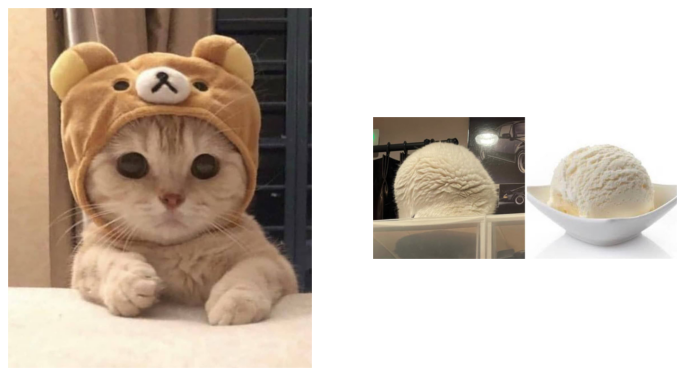

In [ ]:
plot_images([image, image2])

## Vectors and similarities

Well, since we are in the same vector space, we can compute distances and similarities!

In [ ]:
texts = [
    "un gatto con un cappello",
    "una coppia al tramonto",
    "un cavallo in tangenziale",
    "un cavolo, sei amici e un bicchiere d'acqua",
    "una casa con delle maccchine parcheggiate"
]

text_embeds = embed_texts(texts, processor, model)
image_embed = embed_images(image, processor, model)

In [ ]:
similarities = F.cosine_similarity(image_embed, text_embeds)
for text, s in zip(texts, similarities):
    print(text, ":", s.item())

un gatto con un cappello : 0.6288102865219116
una coppia al tramonto : -0.13980108499526978
un cavallo in tangenziale : 0.025765832513570786
un cavolo, sei amici e un bicchiere d'acqua : 0.08357669413089752
una casa con delle maccchine parcheggiate : -0.08402404934167862


Also, since we have vectors, we can try to do some sort of visualization. Using the classical PCA, we can extract a two-dimensional representation of vectors and scatter plot them.

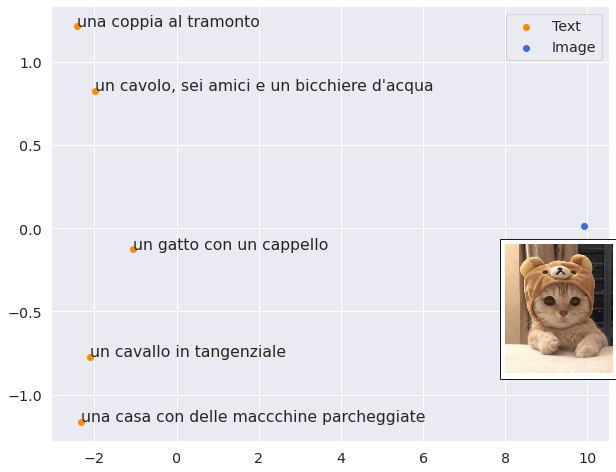

In [ ]:
scatter_with_pca(texts, image)

# Image Retrieval

Let's explore the image retrieval task with a larger collection. Here, we use the Unsplash 25K dataset, a free-to-use collection of pictures by Unsplash.

*We have pre-computed the embeddings of entire dataset (see below the Bonus section).* 😎

In [ ]:
unsplash_images = sorted(glob("unsplash/*"))
unsplash_embeds = torch.load("unsplash_25k_embeddings.pt")
unsplash_embeds.shape

In [ ]:
def image_retrieval(query, image_paths, image_embeddings, top_k=1):
    """Return the top k most similar images to a given textual query"""

    # Create the query vector
    query_embed = embed_texts([query], processor, model)

    # Compute the similarity against all image vectors
    sim = F.cosine_similarity(query_embed, unsplash_embeds)

    # Open the k nearest neighbors
    ranks = sim.argsort(descending=True)
    images = [Image.open(unsplash_images[ranks[k].item()]) for k in range(top_k)]

    return images

query = "Due cani sulla neve" #@param {type:"string"}
images = image_retrieval(query, unsplash_images, unsplash_embeds)
plot_images(images)

# Zero-Shot Image Classification

Pretty much similarly, given some textual labels, one can *classify* an image using similarities.

In [ ]:
labels = [
    "una sedia",
    "un avocado",
    "una televisione",
    "un microfono",
]

In [ ]:
url = "https://cdn.openai.com/dall-e/v2/samples/product_design/YW4gYXJtY2hhaXIgaW4gdGhlIHNoYXBlIG9mIGFuIGF2b2NhZG8uIGFuIGFybWNoYWlyIGltaXRhdGluZyBhbiBhdm9jYWRvLg==_4.png" #@param {type:"string"}
image = get_image_from_url(url)
plot_images(image)

In [ ]:
def classify_image(image, texts):
    image_embed = embed_images(image, processor, model)
    texts_embed = embed_texts(texts, processor, model)

    sim = F.cosine_similarity(image_embed, texts_embed)
    closest = sim.argmax()

    print("Predicted label: ", texts[closest])
    print("-" * 10)
    for s, l in zip(sim, texts):
        print(f"{l}: {s.item():.3f}")


In [ ]:
classify_image(image, labels)

# Bonus: pre-compute of embeddings of a collection of images

Let's see how you can compute and store image embeddings with our model. If you are running on Colab, your fastest option would be using a GPU runtime (Runtime -> Change runtime type -> Hardware accelerator: GPU).

In [ ]:
from datasets import Dataset
from glob import glob

images = sorted(glob("unsplash/*"))

# Create dataset and dataloader
# processor = AutoProcessor.from_pretrained("clip-italian/clip-italian")
dataset = Dataset.from_dict({"path": images})
dataset.set_transform(
    lambda batch: processor(images=[Image.open(p).convert("RGB") for p in batch["path"]])
)
loader = torch.utils.data.DataLoader(dataset, shuffle=False, batch_size=128)

# Setup the model
device = "cuda" if torch.cuda.is_available() else "cpu"
# model = VisionTextDualEncoderModel.from_pretrained("clip-italian/clip-italian")
model.eval()
model.to(device)

image_embeddings = list()
for batch in tqdm(loader, total=len(loader), desc="Batch"):
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        embeds = model.get_image_features(**batch)
    image_embeddings.append(embeds.detach().cpu())

image_embeddings = torch.cat(image_embeddings)

In [ ]:
torch.save(image_embeddings, "unsplash_25k_embeddings.pt")